<a href="https://colab.research.google.com/github/AnhVietPham/Deep-Learning/blob/main/DLTensorflow/MRNN/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l==0.17.0

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [ ]:
def get_params(vocab_size, num_hiddens):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return tf.random.normal(shape=shape, stddev=0.01, mean=0, dtype=tf.float32)

  def three():
    return (tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32),
            tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32),
            tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32))
  
  W_xz, W_hz, b_z = three()
  W_xr, W_hr, b_r = three()
  W_xh, W_hh, b_h = three()

  W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
  b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
  params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
  return params

In [ ]:
def init_gru_state(batch_size, num_hiddens):
  return (tf.zeros((batch_size, num_hiddens)), )

In [ ]:
def gru(inputs, state, params):
  W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []

  for X in inputs:
    X = tf.reshape(X, [-1, W_xh.shape[0]])
    Z = tf.sigmoid(tf.matmul(X, W_xz) + tf.matmul(H, W_hz) + b_z)
    R = tf.sigmoid(tf.matmul(X, W_xr) + tf.matmul(H, W_hr) + b_r)
    H_tilda = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(R * H, W_hh) + b_h)
    H = Z * H + (1 - Z) *H_tilda
    Y = tf.matmul(H, W_hq) + b_q
    outputs.append(Y)
  return tf.concat(outputs, axis = 0), (H,)

perplexity 1.1, 5406.3 tokens/sec on /CPU:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


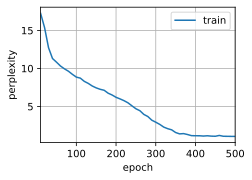

In [ ]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
num_epochs, lr = 500, 1
with strategy.scope():
  model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_gru_state, gru, get_params)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)

perplexity 1.0, 6303.9 tokens/sec on /CPU:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


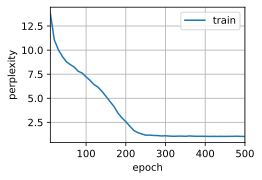

In [ ]:
gru_cell = tf.keras.layers.GRUCell(num_hiddens, kernel_initializer='glorot_uniform')
gru_layers = tf.keras.layers.RNN(gru_cell,time_major=True, return_sequences=True, return_state=True)
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
  model = d2l.RNNModel(gru_layers, vocab_size=len(vocab))

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)